# Compute the condition number given the data, as well as the theoretical one

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
from jax import config
from tqdm import tqdm

from simplecryoem.emfiles import load_data
from simplecryoem.preprocess import preprocess
from simplecryoem.forwardmodel import Slice
from simplecryoem.optimization import Loss, GradV, get_sgd_vol_ops
from simplecryoem.utils import create_3d_mask, generate_uniform_orientations_jax

2024-10-14 03:09:17.588857: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6
config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the files, basic preprocessing etc. Identical to the main Higher_stochastic notebook

In [3]:
data_dir = "../../../../Relion_10076/"
star_file = "my_particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs=True, fourier=False)

load_data: number of partcles: 76186
load_data: data loaded, time:  45.65 sec.


In [4]:
# Extract a subset with fixed seed key so that we always get the same subset.
# Larger sets must be supersets of the smaller sets respectively.

N0 = imgs0.shape[0]
nx0 = imgs0.shape[1]

subset_seed = 60
subset_key = random.PRNGKey(subset_seed)
idx_full = random.permutation(subset_key, N0)

print(subset_key)
print(idx_full[:10])

[ 0 60]
[43308 36879 60295 45796 33465  5621 40298 10802 19736 63364]


In [5]:
out_dir =  "../../../simplecryoem_output/empiar_10076/"

nx_crop = 192  
N = 50000  

idx = idx_full[:N]

In [6]:
len(imgs0)

76186

In [7]:
processed_data = preprocess(imgs0, params0, nx_crop=nx_crop, idx=idx)

imgs_f = processed_data["imgs_f"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

imgs0.shape = (76186, 320, 320)
pixel_size0.shape = (76186,)
angles0.shape = (76186, 3)
shifts0.shape = (76186, 2)
ctf_params0.shape = (76186, 9)
N0 = 76186
idx provided
N = 50000
Taking FFT of the images:
Batch 1/10  7.41 sec.
Batch 2/10  5.15 sec.
Batch 3/10  5.14 sec.
Batch 4/10  5.13 sec.
Batch 5/10  5.14 sec.
Batch 6/10  5.14 sec.
Batch 7/10  5.14 sec.
Batch 8/10  5.14 sec.
Batch 9/10  5.14 sec.
Batch 10/10  5.14 sec.
FFT done. Time:  62.16 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.92000000e+02]
Vectorised imgs_f.shape = (50000, 36864)
Mask radius = 0.22662213740458012
Noise free, setting sigma_noise = 1


In [8]:
# Assuming these variables are the same for all images

pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

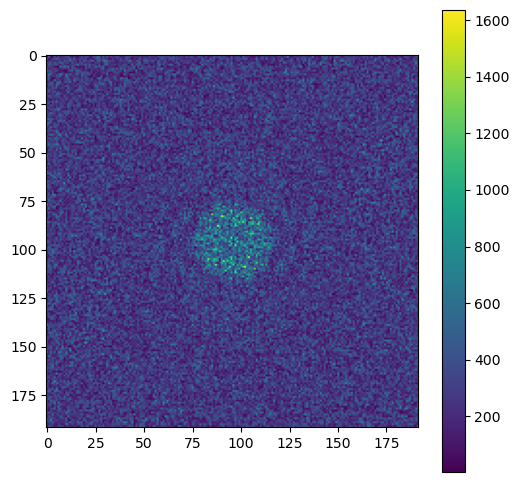

In [9]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[15].reshape([nx_crop, nx_crop]))))
plt.colorbar()

In [10]:
del imgs0

In [11]:
# Apply mask to images

apply_mask = True

if apply_mask:
    # mask2d = mask[0].reshape(-1)
    mask2d = mask[0].reshape(-1)
    imgs_f = imgs_f * mask2d
else:
    mask = jnp.ones(mask.shape)

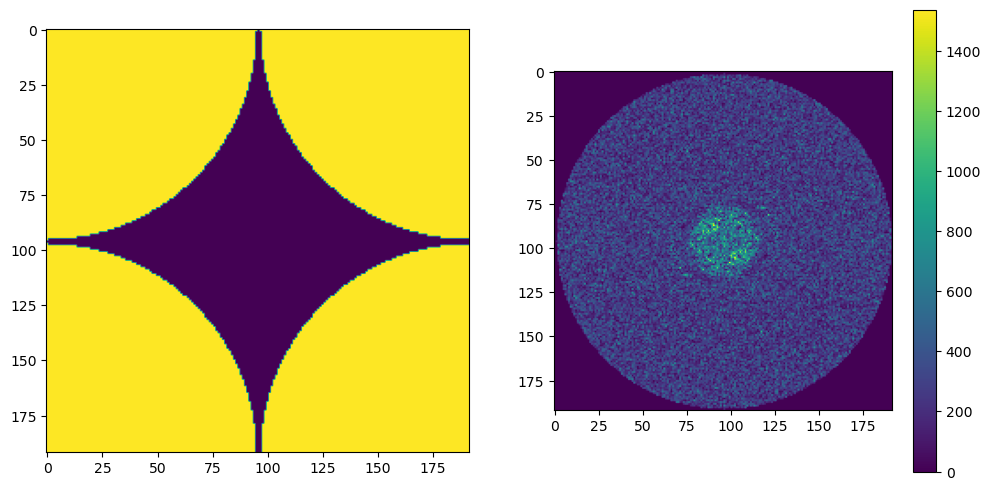

In [12]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)
plt.imshow(mask[0])

plt.subplot(1, 2, 2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx_crop, nx_crop]))))
plt.colorbar()

plt.rcParams["figure.figsize"] = 6, 6

### Useful functions for these experiments

In [15]:
def get_hvp_func(x_grid, angles, imgs, shifts, ctf_params, alpha, interp_method="nn"):
    """Useful function to loop for different x_grids and angles."""

    mask = create_3d_mask(x_grid)

    slice_obj = Slice(x_grid, mask=mask, interp_method=interp_method)
    loss_obj = Loss(slice_obj, alpha=alpha)
    gradv_obj = GradV(loss_obj)

    _, _, hvp_func, _ = get_sgd_vol_ops(
        gradv_obj, loss_obj, angles, shifts, ctf_params, imgs
    )

    return hvp_func


def compute_diagonal_batch(hvp_func, x0, ones, n, batch_sz=500, verbose=False):
    """Compute the diagonal of the _diagonal_ Hessian in batches."""

    assert n % batch_sz == 0, "Make sure n is divisible by batch_sz"

    n_batch = n // batch_sz
    idx_batches = np.array_split(np.arange(n), n_batch)

    nx = x0.shape[0]
    D = np.zeros([nx, nx, nx], dtype=np.complex128)

    if verbose:
        loop_range = tqdm(idx_batches)
    else:
        loop_range = idx_batches

    for idx in loop_range:
        D += hvp_func(x0, ones, idx)

    D = jnp.array(D / n_batch)

    assert jnp.max(jnp.abs(jnp.imag(D))) < 1e-16

    return jnp.real(D)


def compute_shell_bounds(grid):
    """Given a grid object of the form [dr, nx], return an array of resolutions
    that divide the Fourier space into shells of width dr.

    The code is similar to the one in the src.fsc.average_shells
    and src.fsc.average_shells_2d functions
    except that res represents the upper bounds of the shells, not the midpoints.
    """

    dr = x_grid[0]

    # Calculate the radius in the Fourier domain.
    x_freq = np.fft.fftfreq(int(grid[1]), 1 / (grid[0] * grid[1]))
    X, Y, Z = np.meshgrid(x_freq, x_freq, x_freq)
    r = np.sqrt(X**2 + Y**2 + Z**2)

    # Max radius so that the shells are not outside the
    # rectangular domain.
    max_rad = np.max(r[:, 0, 0])

    # Calculate the shells.
    res = []
    R = -dr / 2
    while R + dr <= max_rad:
        res.append(R + dr)
        R += dr

    res = np.array(res)

    return res


def compute_condition_number_diag(d, x_grid, radius=None):
    """Compute the condition number of the diagonal matrix whose diagonal is d."""

    mask = create_3d_mask(x_grid, radius=radius)
    d = jnp.abs(d * mask)

    d_max = jnp.max(d)
    d_min = jnp.min(d[d > 0])

    return d_max / d_min, d_max, d_min


def compute_cond_lower_bound(x_grid, n, alpha, radius=None):
    """Compute the theoretical lower bound on the condition number for the diagonal
    Hessian matrix whose diagonal is d."""

    mask = create_3d_mask(x_grid, radius=radius)

    pts_3d = jnp.sum(mask > 0)
    pts_2d = jnp.sum(mask[0] > 0)

    p = pts_2d / pts_3d

    return (n + alpha) / (n * p + alpha)

### Compute the condition number for the loaded dataset

In [16]:
alpha = 1e-8  
interp_method = "nn"

# Use ctf_params0 to compute the condition number without CTF
ctf_params0 = jnp.array(N * [None]).reshape((N,1))

# With CTF
hvp_func = get_hvp_func(x_grid, angles, imgs_f, shifts, ctf_params, alpha, interp_method)

# Without CTF
hvp_func0 = get_hvp_func(x_grid, angles, imgs_f, shifts, ctf_params0, alpha, interp_method)

In [17]:
# Compute the Hessian diagonals exactly (valid for NN interpolation) -
# In batches
# Full diagonal

key = random.PRNGKey(62)
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx, nx, nx], dtype=jnp.complex128)
ones = jnp.ones(x0.shape, dtype=jnp.complex128)

D = compute_diagonal_batch(hvp_func, x0, ones, N, verbose=True)
D0 = compute_diagonal_batch(hvp_func0, x0, ones, N, verbose=True)

100%|███████████████████████████████| 100/100 [00:09<00:00, 10.15it/s]


kappa(H) = 4915403.9435676895
kappa(H_noCTF) = 100000000.99999978


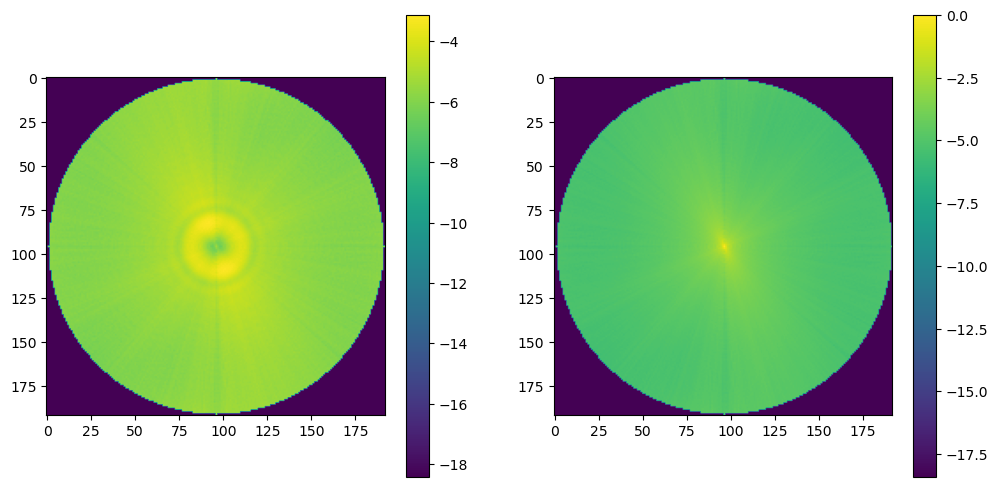

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(jnp.fft.fftshift(jnp.log(D[0])))
plt.colorbar()
plt.subplot(122)
plt.imshow(jnp.fft.fftshift(jnp.log(D0[0])))
plt.colorbar()
print(f"kappa(H) = {jnp.max(D)/jnp.min(D)}")
print(f"kappa(H_noCTF) = {jnp.max(D0)/jnp.min(D0)}")

In [19]:
# Fourier resolution shell bounds

res = compute_shell_bounds(x_grid)

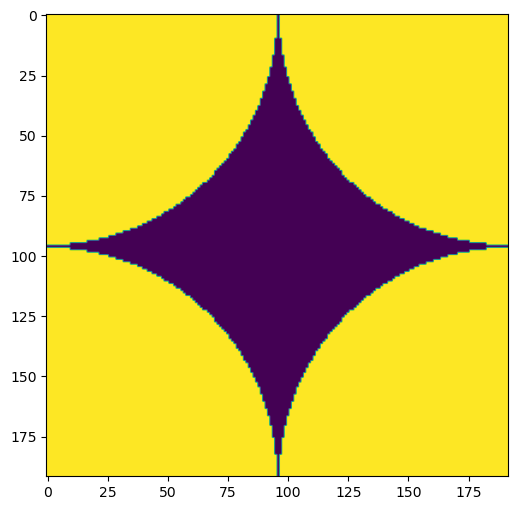

In [20]:
plt.imshow(create_3d_mask(x_grid, [0, 0, 0], res[-1])[0])

In [21]:
cond = []
cond0 = []

D_maxs = []
D_maxs0 = []

D_mins = []
D_mins0 = []

cond_bound = []

for r in tqdm(res):
    kappa, D_max, D_min = compute_condition_number_diag(D, x_grid, radius=r)
    kappa0, D_max0, D_min0 = compute_condition_number_diag(D0, x_grid, radius=r)

    kappa_bound = compute_cond_lower_bound(x_grid, N, alpha, r)

    D_maxs.append(D_max)
    D_maxs0.append(D_max0)

    D_mins.append(D_min)
    D_mins0.append(D_min0)

    cond.append(kappa)
    cond0.append(kappa0)

    cond_bound.append(kappa_bound)

100%|█████████████████████████████████| 96/96 [00:41<00:00,  2.32it/s]


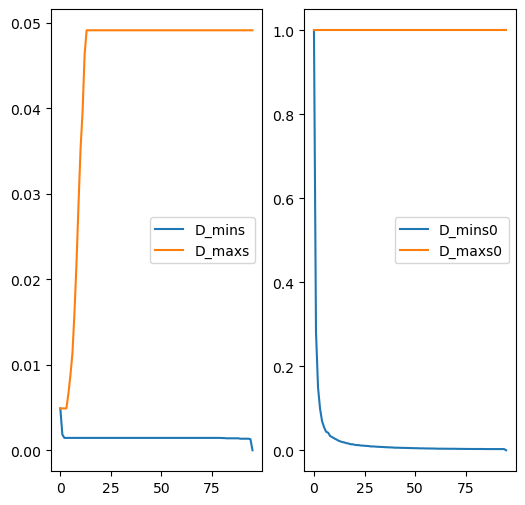

In [22]:
plt.subplot(121)
plt.plot(D_mins)
plt.plot(D_maxs)
plt.legend(["D_mins", "D_maxs"])

plt.subplot(122)
plt.plot(D_mins0)
plt.plot(D_maxs0)
plt.legend(["D_mins0", "D_maxs0"])

In [23]:
savefig = False

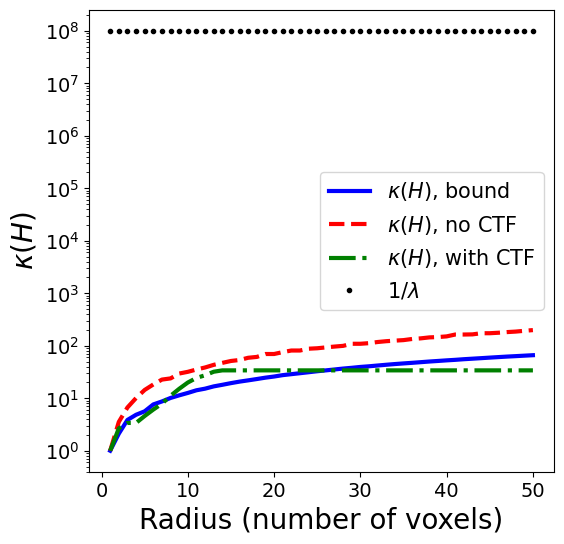

In [24]:
plot_range = 50

x_range = np.arange(1, plot_range+1)

plt.semilogy(x_range, cond_bound[:plot_range], "b", linewidth=3)
plt.semilogy(x_range, cond0[:plot_range], "r--", linewidth=3)
plt.semilogy(x_range, cond[:plot_range], "g-.", linewidth=3)
plt.semilogy(x_range, 1 / alpha * jnp.ones((plot_range,)), "k.", linewidth=3)

plt.xticks(fontsize="14")
plt.yticks(fontsize="14")
plt.xlabel("Radius (number of voxels)", fontsize="20")
plt.ylabel("$\kappa(H)$", fontsize="20")
plt.legend(
    [
        "$\kappa(H)$, bound",
        "$\kappa(H)$, no CTF",
        "$\kappa(H)$, with CTF",
        "$1/\lambda$",
    ],
    fontsize="15",
)

if savefig:
    plt.savefig(f"cond_number_empirical_vs_theoretical.eps")
    plt.savefig(f"cond_number_empirical_vs_theoretical_tight.eps", bbox_inches="tight")

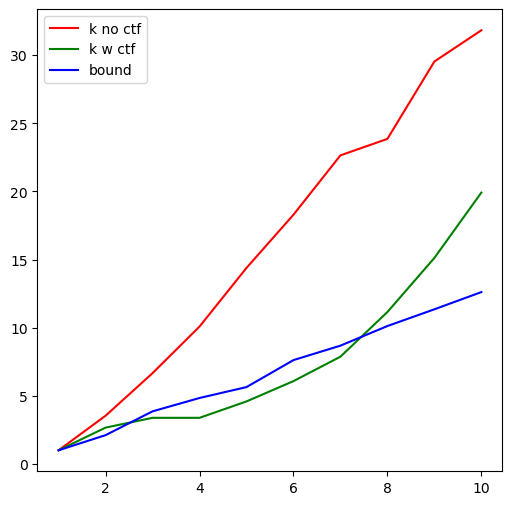

In [27]:
# A closer look at the plot above

upto = 10

plt.plot(x_range[:upto], jnp.array(cond0[:upto]), 'r')
plt.plot(x_range[:upto], jnp.array(cond[:upto]), 'g')
plt.plot(x_range[:upto], cond_bound[:upto], 'b')
plt.legend(['k no ctf', 'k w ctf', 'bound'])

### Histogram of angles in the dataset

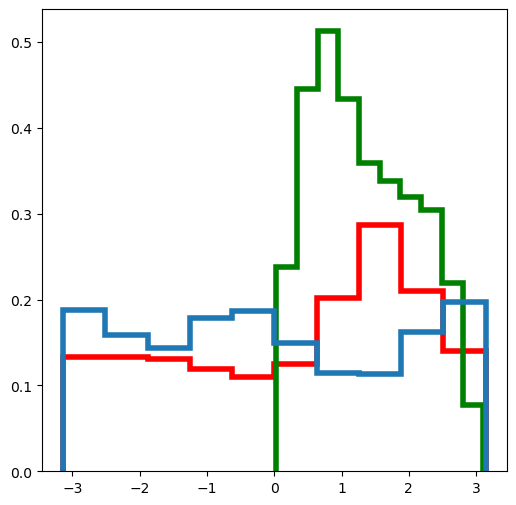

In [28]:
n_bins = 10

fig, ax = plt.subplots()
bins1, bin_edges1, _ = plt.hist(
    angles[:, 0], n_bins, density=True, histtype="step", color="r", alpha=1, linewidth=4
)
bins2, bin_edges2, _ = plt.hist(
    angles[:, 1], n_bins, density=True, histtype="step", color="g", alpha=1, linewidth=4
)
bins3, bin_edges3, _ = plt.hist(
    angles[:, 2], n_bins, density=True, histtype="step", alpha=1, linewidth=4
)

## Similar plot for uniformly distributed angles, with error bars

In [29]:
key = random.PRNGKey(20)
alpha = 1e-8
interp_method = "nn"

In [30]:
nx_range = np.arange(0, 312, 16)
nx_range[0] = 1
print(nx_range)

[  1  16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272
 288 304]


In [ ]:
n = 10000
n_samples = 10

ks = np.zeros((len(nx_range), n_samples))
ks_bound = np.zeros((len(nx_range), )) 

for idx_nx, nx in enumerate(tqdm(nx_range)):

    x_grid0 = np.array([1, nx])

    angles0 = np.zeros((n, 3), dtype = np.float64)
    imgs0 = np.zeros((n, nx**2), dtype = np.complex128)
    shifts0 = np.zeros((n, 2), dtype = np.float64)
    sigma_noise0 = np.ones((nx**2,), dtype = np.float64)
    ctf_params0 = jnp.array(n * [None]).reshape((n,1))
    x0 = np.zeros((nx, nx, nx), dtype = jnp.complex128)
    ones = np.ones((nx, nx, nx), dtype = jnp.complex128)

    # The theoretical bound
    cond_bound = compute_cond_lower_bound(x_grid0, n, alpha)
    ks_bound[idx_nx] = cond_bound

    # The condition number for uniform orientations
    key, *subkeys = random.split(key, n_samples + 1)

    for idx_sample in range(n_samples):
        angles = generate_uniform_orientations_jax(subkeys[idx_sample], angles0)
        hvp_func = get_hvp_func(x_grid0, angles, imgs0, shifts0, ctf_params0, alpha)

        d = compute_diagonal_batch(hvp_func, x0, ones, n)
        cond, _, _ = compute_condition_number_diag(d, x_grid0)

        ks[idx_nx, idx_sample] = cond

In [32]:
ks_mean = np.mean(ks, axis = 1)
ks_upper = np.max(ks, axis = 1) - ks_mean
ks_lower = ks_mean - np.min(ks, axis = 1)
ks_lims = np.vstack((ks_lower, ks_upper))

In [33]:
print(ks.shape)
print(ks_bound.shape)

(20, 10)
(20,)


In [34]:
savefig = False

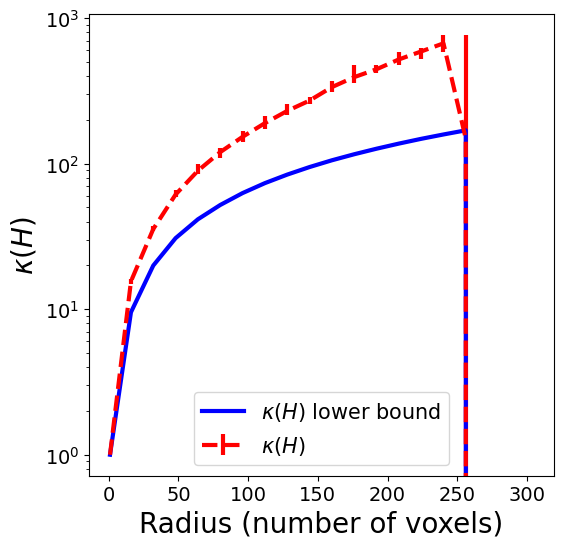

In [35]:
plt.errorbar(nx_range, ks_mean, yerr = ks_lims, label="$\kappa(H)$", c="r", linestyle="--", linewidth=3)
plt.semilogy(nx_range, ks_bound, label = "$\kappa(H)$ lower bound", c="b", linewidth=3)
#plt.semilogy(nx_range, 1 / alpha * np.ones((len(nx_range),)), "k.", linewidth=3, label ="$1/\lambda$")
plt.legend(fontsize=15)

plt.xticks(fontsize="14")
plt.yticks(fontsize="14")
plt.xlabel("Radius (number of voxels)", fontsize="20")
plt.ylabel("$\kappa(H)$", fontsize="20")

if savefig:
    plt.savefig("cond_number_uniform_angles_vs_bound_logy.eps")
    plt.savefig("cond_number_uniform_angles_vs_bound_logy_tight.eps", bbox_inches="tight")

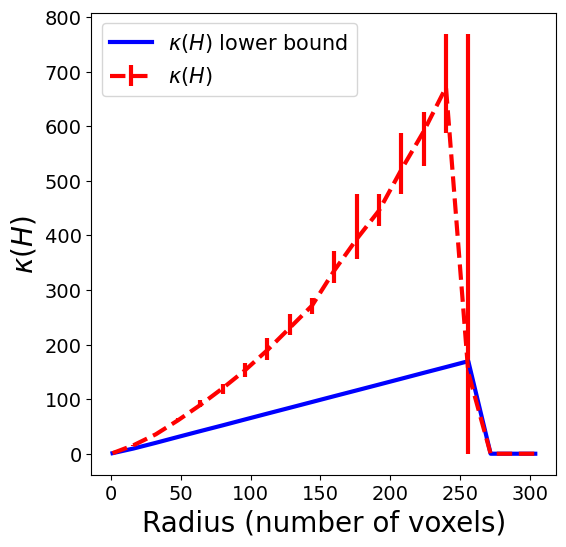

In [36]:
plt.errorbar(nx_range, ks_mean, yerr = ks_lims, label="$\kappa(H)$", c="r", linestyle="--", linewidth=3)
plt.plot(nx_range, ks_bound, label = "$\kappa(H)$ lower bound", c="b", linewidth=3)
#plt.plot(nx_range, 1 / alpha * np.ones((len(nx_range),)), "k.", linewidth=3, label ="$1/\lambda$")
plt.legend(fontsize=15)

plt.xticks(fontsize="14")
plt.yticks(fontsize="14")
plt.xlabel("Radius (number of voxels)", fontsize="20")
plt.ylabel("$\kappa(H)$", fontsize="20")

if savefig:
    plt.savefig("cond_number_uniform_angles_vs_bound.eps")
    plt.savefig("cond_number_uniform_angles_vs_bound_tight.eps", bbox_inches="tight")

## And some examples of the diagonal of the Hessian

In [37]:
key = random.PRNGKey(2)
key, sk1, sk2 = random.split(key, 3)

In [38]:
n = 5

nx = 256
x_grid0 = np.array([1, nx])

angles0 = np.zeros((n, 3), dtype = np.float64)
imgs0 = np.zeros((n, nx**2), dtype = np.complex128)
shifts0 = np.zeros((n, 2), dtype = np.float64)
sigma_noise0 = np.ones((nx**2,), dtype = np.float64)
ctf_params0 = jnp.array(n * [None]).reshape((n,1))
x0 = np.zeros((nx, nx, nx), dtype = jnp.complex128)
ones = np.ones((nx, nx, nx), dtype = jnp.complex128)

In [39]:
angles = generate_uniform_orientations_jax(sk1, angles0)
hvp_func = get_hvp_func(x_grid0, angles, imgs0, shifts0, ctf_params0, alpha)
d1 = compute_diagonal_batch(hvp_func, x0, ones, n, batch_sz=n)

In [40]:
savefig = False

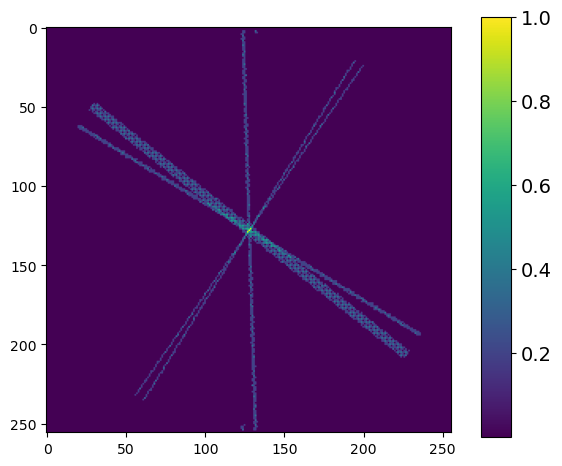

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(jnp.fft.fftshift(d1[0]))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig("diagonal_uniform_noCTF_n5_nx256.eps", bbox_inches="tight")

In [42]:
### And the same for n=100

n = 100

nx = 256
x_grid0 = np.array([1, nx])

angles0 = np.zeros((n, 3), dtype = np.float64)
imgs0 = np.zeros((n, nx**2), dtype = np.complex128)
shifts0 = np.zeros((n, 2), dtype = np.float64)
sigma_noise0 = np.ones((nx**2,), dtype = np.float64)
ctf_params0 = jnp.array(n * [None]).reshape((n,1))
x0 = np.zeros((nx, nx, nx), dtype = jnp.complex128)
ones = np.ones((nx, nx, nx), dtype = jnp.complex128)

In [43]:
angles = generate_uniform_orientations_jax(sk2, angles0)
hvp_func = get_hvp_func(x_grid0, angles, imgs0, shifts0, ctf_params0, alpha)
d2 = compute_diagonal_batch(hvp_func, x0, ones, n, batch_sz=n)

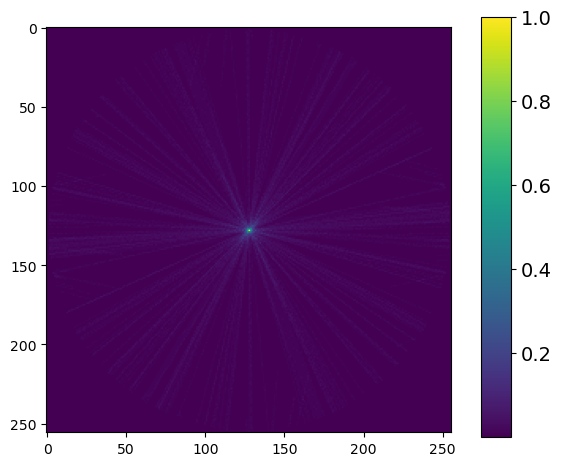

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(jnp.fft.fftshift(d2[0]))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig("diagonal_uniform_noCTF_n100_nx256.eps", bbox_inches="tight")